In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.svm import NuSVR

In [2]:
training_ridge = np.loadtxt('TrainingRidge.csv', delimiter = ',',\
                            skiprows = 1)
validation_ridge = np.loadtxt('ValidationRidge.csv', delimiter = ',',\
                            skiprows = 1)

$\textbf{Part[a]: Training the $\nu$-SVR}$

The mean squared error for the model on the validation set is: [35.43480913 32.73695991 29.1007286  ... 39.77193659 40.30416022
 40.53816058]


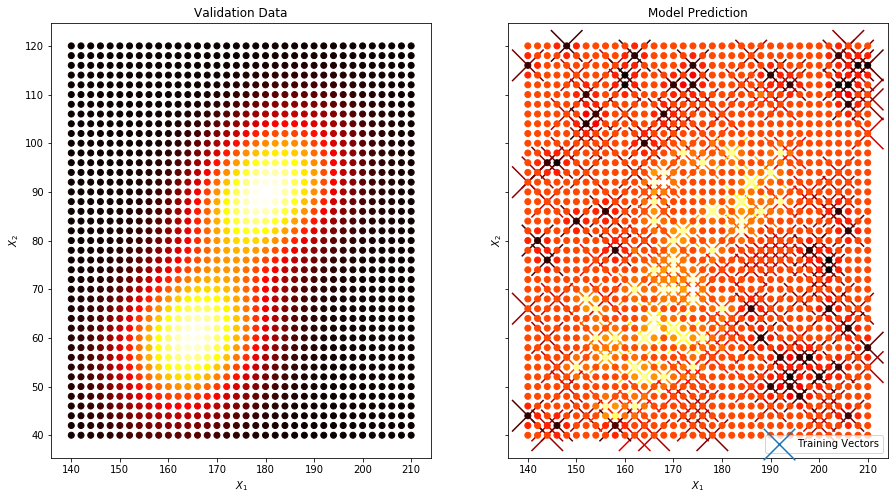

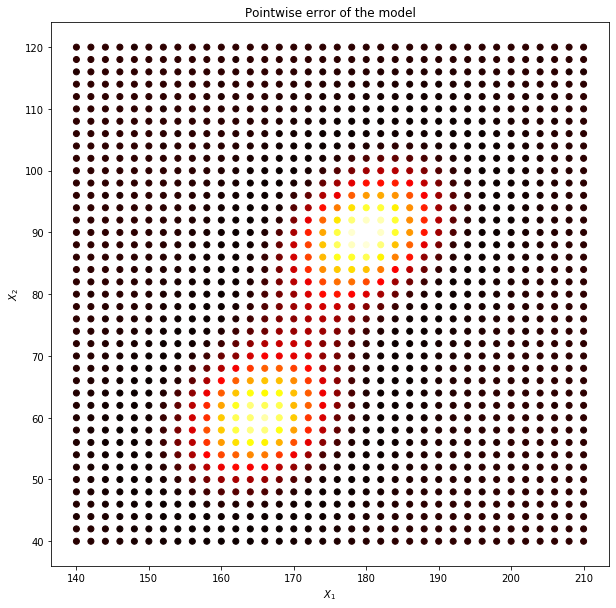

In [19]:
def run_model (clf, validation_ridge, training_ridge):
    
    params = clf.get_params(deep = True)
    
    clf.fit(training_ridge[:,:2], training_ridge[:,2])
    
    prediction = clf.predict(np.array([validation_ridge[:,0], \
                                    validation_ridge[:,1]]).T)
    
    pairwise_err = np.power(validation_ridge[:,2] - prediction, 2)
    
    mse = sklearn.metrics.mean_squared_error(validation_ridge[:,2], prediction)
    
    score = clf.score(validation_ridge[:,:2], validation_ridge[:,2])
    
    return {"model": clf, "pred": prediction, "err": mse, \
            "score": score, "par": params, "p_err": pairwise_err}

clf = NuSVR(gamma = "auto")

print("The mean squared error for the model on the validation set is: {}"\
              .format(run_model(clf, validation_ridge, \
                                training_ridge)["p_err"]))

def plot_colorMap (clf, validation_ridge = validation_ridge):
    
    result = run_model(clf, validation_ridge, training_ridge)
    
    prediction, mse, err = result["pred"], result["err"], result["p_err"]
    
    fig, axs = plt.subplots(1,2, sharex = True, sharey = True, figsize = (15,8))
    
    axs[1].scatter(training_ridge[:,0],\
                   training_ridge[:,1], \
                   c = training_ridge[:,2], \
                   marker = 'x',
                   s = 1000,
                   cmap = 'hot',
                   label = 'Training Vectors')
    axs[1].set_title('Model Prediction')
    axs[1].set_xlabel('$X_1$')
    axs[1].set_ylabel('$X_2$')
    axs[1].legend()
    
    
    axs[0].scatter(validation_ridge[:,0],\
                   validation_ridge[:,1], \
                   c = validation_ridge[:,2], \
                   cmap = 'hot' )
    axs[0].set_title('Validation Data')
    axs[0].set_xlabel('$X_1$')
    axs[0].set_ylabel('$X_2$')
    
    axs[1].scatter(validation_ridge[:,0],\
                   validation_ridge[:,1], \
                   c = prediction, \
                   cmap = 'hot',
                   label = 'Training Vectors')
    
    plt.figure(figsize = (10,10))
    
    plt.scatter(validation_ridge[:,0],\
                validation_ridge[:,1],\
                c = err, \
                cmap = 'hot')
    plt.title("Pointwise error of the model")
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
     
plot_colorMap(NuSVR(gamma = 'auto'))


    




$\textbf{Observation:}$ So, with an out of the box implementation, we do not get nearly enough  the performance we would wish. In particular, while we get decent performance on the training set, we do not get good performance on the data previously unseen by the model. The model is thus intensely overfitting. The lower plot shows the error per point in the plane. We can see that a naive regression model is performs worst in the high value areas. The main reason is that $C$ is not large enough and does not allow the model to be somewhat slack.

$\textbf{Part[b]: Cross Validation}$ 

In [4]:
from sklearn.model_selection import KFold

In [8]:
def kfold_cross_validation (num_Fold, params, X = training_ridge):
    
    #========================================================================
    """
    1. Fit the model to the X_train data
    2. Get the score of the model on the Y_train test set
    3. Average the score over all different splits.
    4. Store the parameters and their average score
    
    """
    #======================================================================== 
    
    kfold = KFold(n_splits = num_Fold, shuffle = True, random_state = 0)
    
    Cs, nus = np.meshgrid(params["C"], params["Nu"])
    
    params_matr = np.array([(Cs[i,j], nus[i,j]) for i in range(Cs.shape[0])\
                                                for j in range(Cs.shape[1])])
    counter = 0
    
    scores = np.zeros(params_matr.shape[0]) 
    
    for C, nu in params_matr:

        mse = 0
        
        clf = NuSVR(gamma = 'auto', C = C, nu = nu)
    
        for train, test in kfold.split(X):
            
            X_train, X_test = X[train], X[test]
            
            result = run_model(clf, X_test, X_train)
        
            mse += result["err"]
            
        scores[counter] = mse / num_Fold
            
        counter += 1 
        
    return scores, params_matr[np.argmin(scores)]

#========================================================================

#Define some parameter dictionaries for testing

 
params_dict = {"C": [2**float(i) for i in np.arange(-2,12)], \
               "Nu": [2**float(j) for j in np.arange(-12,0)]}

result = kfold_cross_validation(10, params_dict)

print(r"The best parameter configuration is: C = {}, $\nu$ = {}"\
                      .format(result[1][0], result[1][1]))

#========================================================================

The best parameter configuration is: C = 128.0, $\nu$ = 0.5


$\textbf{Part[c]: Re-training the entire network on optimal parameters}$

The best parameter configuration is: C = 128.0, $\nu$ = 0.5
60.81358433582594


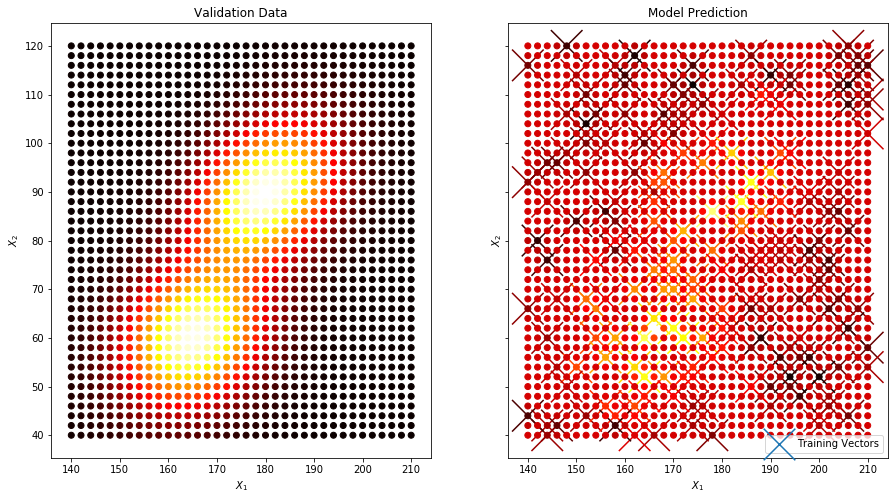

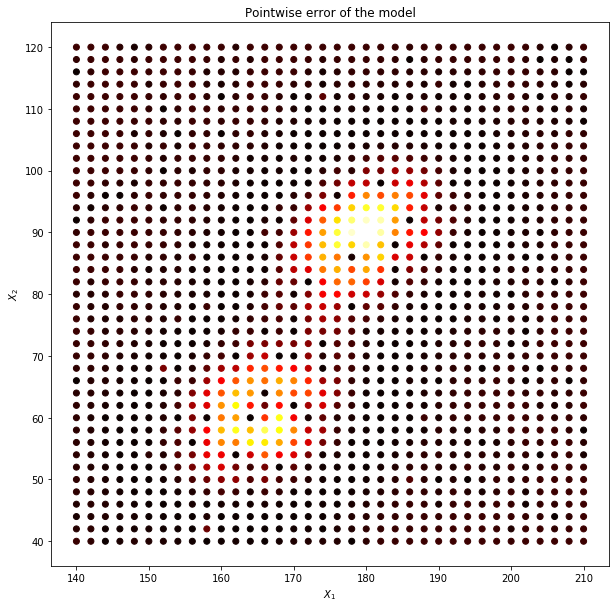

In [21]:
def train_best_model(params):
    
    result = kfold_cross_validation(10, params)

    print(r"The best parameter configuration is: C = {}, $\nu$ = {}"\
                      .format(result[1][0], result[1][1]))
    
    clf = NuSVR(gamma = 'auto', C = result[1][0], nu = result[1][1])
    
    return run_model(clf, validation_ridge, training_ridge)


best_model_results = train_best_model(params_dict)
print(best_model_results['err'])
plot_colorMap(best_model_results["model"])

$\textbf{Observation:}$ A couple of things are obvious. Firstly, the model performance increases; the MSE goes down from the original implementation. But the improvement is achieved at the cost of getting predictions exactly right, especially on high-valued portion of the data. Rather, the improvement is achieved – as can be seen by comparing the top-right plots from now and earlier – by lowering the average prediction across $all$ the data (as can be surmised from the fact that the plot becomes much $\underline{darker}$). The bottom plot shows that, nevertheless, the residual error remains pretty high.